# VAE from scratch

In [7]:
import os
from IPython.display import clear_output
import shutil
import pathlib
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np

In [8]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.0

GPU is AVAILABLE


# Preparing the data

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Reading the data</b></p>
</div>

In [9]:
# get the files paths
input_dir_path = "/kaggle/input"
working_dir_path = "/kaggle/working"
input_dir_path = input_dir_path if os.path.exists(input_dir_path) else ".{}".format(input_dir_path)
working_dir_path = working_dir_path if os.path.exists(working_dir_path) else ".{}".format(working_dir_path)

img_dir_path = os.path.join(input_dir_path, "celeba-dataset", "img_align_celeba", "img_align_celeba")

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>CNN</b></p>
</div>

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>tf.data.Dataset</b></p>
</div>

In [10]:
ds = tf.keras.utils.image_dataset_from_directory(
    img_dir_path,
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

Found 202599 files belonging to 1 classes.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-13 05:18:35.733883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-13 05:18:35.734280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
ds = ds.map(lambda x: x / 255.)

2023-03-13 05:21:23.631175: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


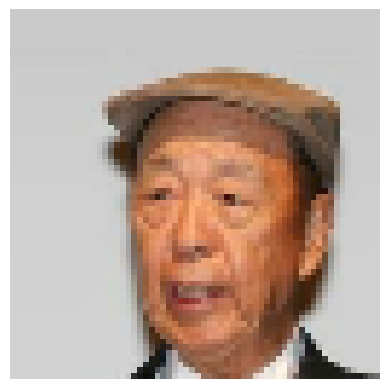

In [13]:
for x in ds:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Discriminator</b></p>
</div>

In [14]:
discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Generator</b></p>
</div>

In [16]:
latent_dim = 128

generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(8 * 8 * 128),
        tf.keras.layers.Reshape((8, 8, 128)),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [17]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Data Augmentation</b></p>
</div>

In [59]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.2),
        ]
    )

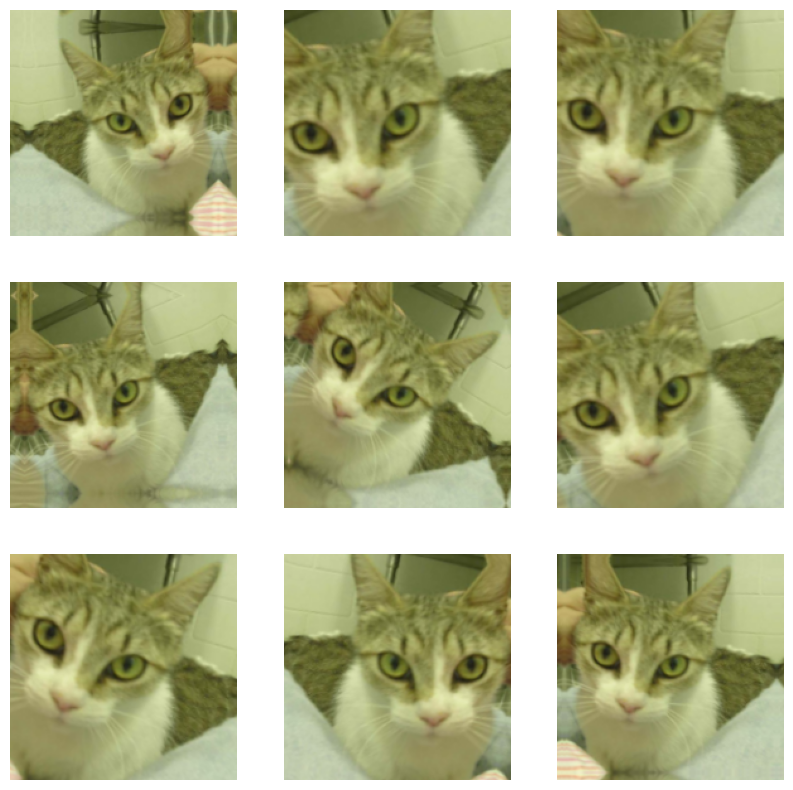

In [60]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Build Model</b></p>
</div>

In [62]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
cnn = tf.keras.Model(inputs=inputs, outputs=outputs)

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Training</b></p>
</div>

In [63]:
cnn.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

EPOCHS = 30
checkpoint_filepath = '/tmp/checkpoint/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
history = cnn.fit(
    train_ds, 
    epochs=EPOCHS, 
    callbacks=callbacks_list,
    validation_data=val_ds)

Epoch 1/30


2023-03-12 05:20:49.362259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


547/547 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.5789

2023-03-12 05:22:11.408427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


547/547 [==============================] - 87s 157ms/step - loss: 0.6750 - accuracy: 0.5789 - val_loss: 0.6126 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 2/30
547/547 [==============================] - 79s 145ms/step - loss: 0.6073 - accuracy: 0.6750 - val_loss: 0.5145 - val_accuracy: 0.7496 - lr: 0.0010
Epoch 3/30
547/547 [==============================] - 83s 152ms/step - loss: 0.5454 - accuracy: 0.7289 - val_loss: 0.4660 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 4/30
547/547 [==============================] - 89s 163ms/step - loss: 0.4890 - accuracy: 0.7650 - val_loss: 0.4004 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 5/30
547/547 [==============================] - 86s 158ms/step - loss: 0.4554 - accuracy: 0.7910 - val_loss: 0.5748 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 6/30
547/547 [==============================] - 92s 169ms/step - loss: 0.4125 - accuracy: 0.8130 - val_loss: 0.3369 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 7/30
547/547 [==============================] - 82s 149ms

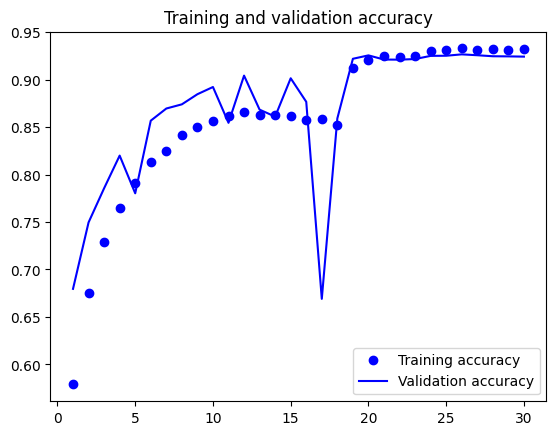

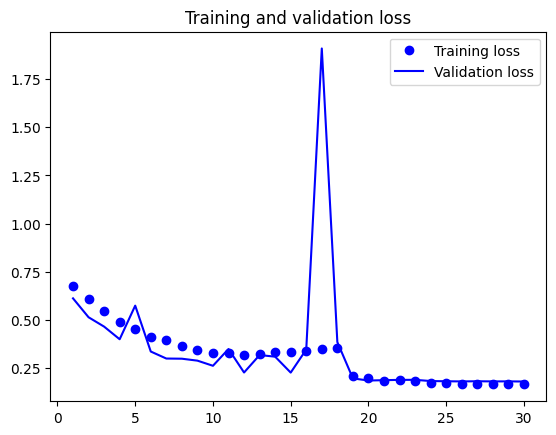

In [64]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [65]:
cnn.load_weights(checkpoint_filepath) 

# print the model metrics
loss, accuracy = cnn.evaluate(val_ds)
print(f"Validation accuracy: {accuracy}")
print(f"Validation loss: {loss}")

235/235 [==============================] - 5s 21ms/step - loss: 0.1812 - accuracy: 0.9243
Validation accuracy: 0.9242666959762573
Validation loss: 0.1812412142753601


# Testing

In [72]:
# make predictions on the test data and display the probabilities of images being dogs
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_path,
    image_size=(180, 180),
    batch_size=32,
    shuffle=False,
    label_mode=None,
)

predictions = cnn.predict(test_ds)

Found 12500 files belonging to 1 classes.
391/391 [==============================] - 8s 19ms/step


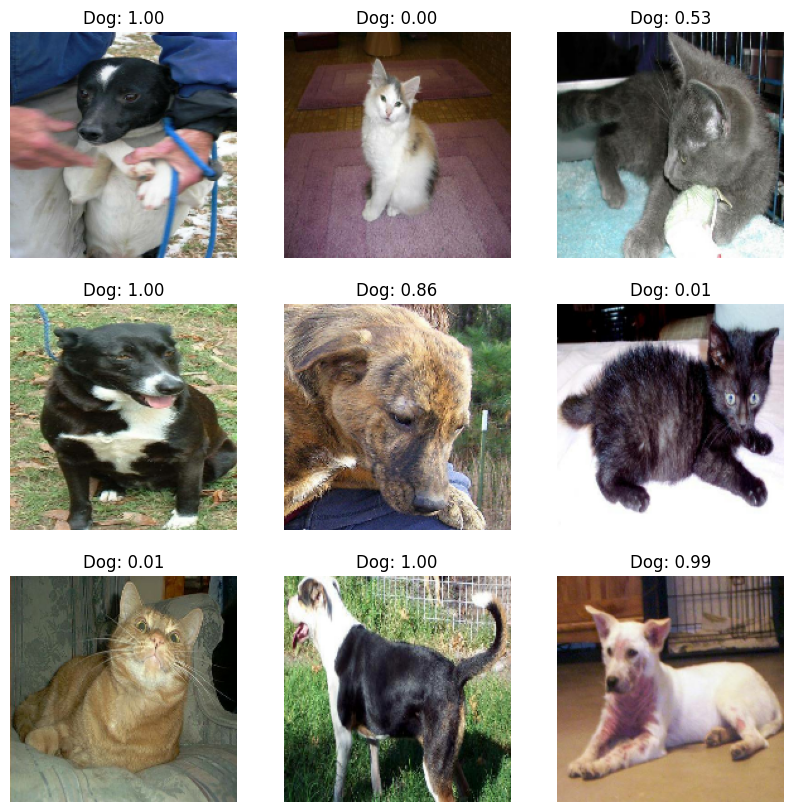

In [87]:
# display the first 9 images in the test directory with their predicted probabilities and labels
plt.figure(figsize=(10, 10))
for images in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Dog: {predictions[i][0]:.2f}")
        plt.axis("off")


In [94]:
# make a submission file using predictions formatted as float numbers with 2 decimal places
submission = pd.DataFrame({"id": os.listdir(test_dir_path), "label": predictions.reshape(-1)})
submission["id"] = submission["id"].apply(lambda x: x.split(".")[0])
submission["label"] = submission["label"].apply(lambda x: f"{x:.2f}")

#sort the submission file by id (integer)
submission["id"] = submission["id"].astype(int)
submission = submission.sort_values(by="id")

submission.to_csv("submission.csv", index=False)